DNN, RNN 적용하기, RNN에 `callback.LearningRateScheduler` 적용하여 loss가 가장 낮은 지점의 Learning rate 찾기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

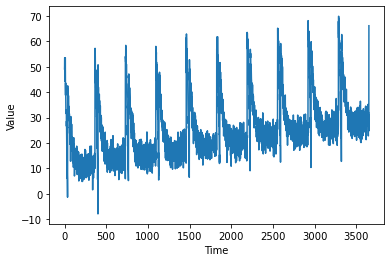

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10 # YOUR CODE HERE #
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005 # YOUR CODE HERE#
noise_level = 3 # YOUR CODE HERE#

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## 간단한 DNN 모델 적용해보기

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)) # momentum은 0.9가 국룰!
model.fit(dataset,epochs=100,verbose=0)


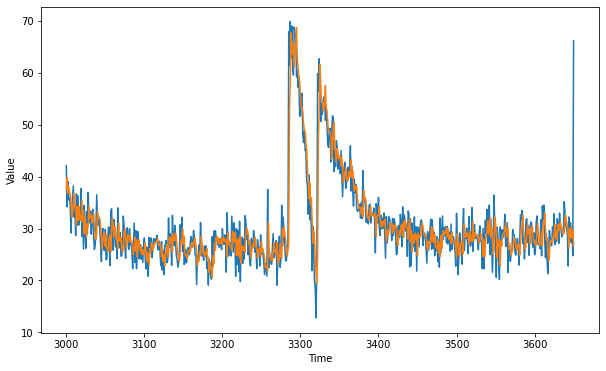

In [5]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [6]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.109435

## RNN 적용
* Callback : `LearningRateScheduler`

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100.0)
])

### Callback 적용

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
94/94 [==============================] - 1s 10ms/step - loss: 6.8086 - mae: 7.2826 - lr: 1.0000e-08
Epoch 2/50
94/94 [==============================] - 2s 17ms/step - loss: 6.7746 - mae: 7.2483 - lr: 1.1220e-08
Epoch 3/50
94/94 [==============================] - 1s 10ms/step - loss: 6.7430 - mae: 7.2164 - lr: 1.2589e-08
Epoch 4/50
94/94 [==============================] - 1s 10ms/step - loss: 6.7005 - mae: 7.1737 - lr: 1.4125e-08
Epoch 5/50
94/94 [==============================] - 1s 11ms/step - loss: 6.6617 - mae: 7.1345 - lr: 1.5849e-08
Epoch 6/50
94/94 [==============================] - 1s 11ms/step - loss: 6.6172 - mae: 7.0912 - lr: 1.7783e-08
Epoch 7/50
94/94 [==============================] - 1s 9ms/step - loss: 6.5714 - mae: 7.0441 - lr: 1.9953e-08
Epoch 8/50
94/94 [==============================] - 1s 10ms/step - loss: 6.5165 - mae: 6.9893 - lr: 2.2387e-08
Epoch 9/50
94/94 [==============================] - 1s 12ms/step - loss: 6.4618 - mae: 6.9342 - lr: 2.5119e-08
Ep

(1e-08, 0.0001, 0.0, 30.0)

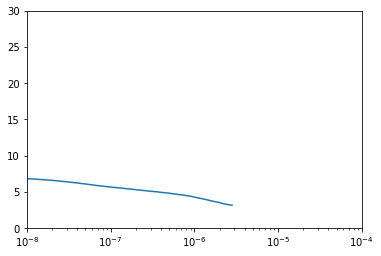

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

FROM THIS PICK A LEARNING RATE

### Loss가 안정적인 Learning rate값 선택하여 다시 학습

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=50,verbose=1)

Epoch 1/50
94/94 [==============================] - 1s 13ms/step - loss: 263.1988 - mae: 10.1378
Epoch 2/50
94/94 [==============================] - 1s 10ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/50
94/94 [==============================] - 1s 13ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/50
94/94 [==============================] - 1s 10ms/step - loss: 31.9159 - mae: 3.9759
Epoch 5/50
94/94 [==============================] - 1s 10ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/50
94/94 [==============================] - 2s 18ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/50
94/94 [==============================] - 1s 10ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/50
94/94 [==============================] - 1s 11ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/50
94/94 [==============================] - 1s 14ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/50
94/94 [==============================] - 1s 12ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/50
94/94 [============================

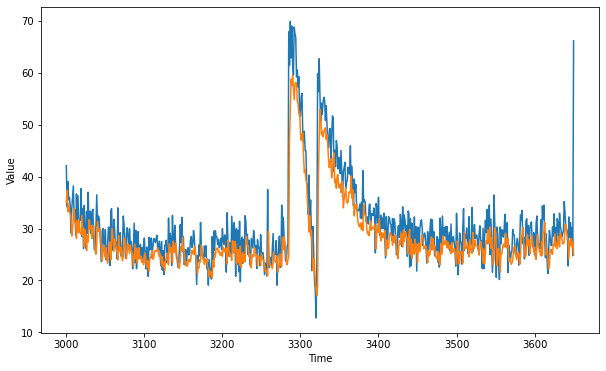

In [16]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.5835395